# Preprocessing

In [21]:
# from google.colab import drive
# drive.mount('/content/gdrive')

In [1]:
import tensorflow as tf
import tensorflow.keras as k

In [10]:
import numpy as np

In [14]:
# # set train dir origin
# dir_data_gdrive = "/content/gdrive/MyDrive/coursework/p_final_project/project_02/data/sampled"
# !cp -r "/content/gdrive/MyDrive/coursework/p_final_project/project_02/data/sampled" "/content/data"
# dir_data = "/content/data"

In [11]:
dir_data = r"C:\Users\rapha\My Drive\Work\jedha_dsfs\coursework\p_final_project\project_02\data\eyes_only"

In [14]:
BATCH_SIZE = 64
IMAGE_SIZE = (86, 86)
MODEL_INPUT = IMAGE_SIZE + (3,)

In [12]:
import os

dir_drowsy = os.path.join(dir_data, 'closed_eye')
dir_non_drowsy = os.path.join(dir_data, 'open_eye')

files_drowsy = os.listdir(dir_drowsy)
files_non_drowsy = os.listdir(dir_non_drowsy)

positive_count = len(files_drowsy)
negative_count = len(files_non_drowsy)

print(f"Positive images: {positive_count}")
print(f"Negative images: {negative_count}")
print(f"Positive to negative ratio: {round(positive_count/(positive_count + negative_count), 2)}")

Positive images: 24001
Negative images: 24001
Positive to negative ratio: 0.5


In [15]:
"""
train_datagen = ImageDataGenerator(...,
                                   preprocessing_function=convert_grayscale_to_three_rank,
                                   ...)
"""

def preprocess_data(image):

    def convert_grayscale_to_three_rank(image):
        # Check if the image has a single channel (grayscale)
        if image.shape[-1] == 1:
            image = np.stack((image,)*3, axis=-1)
        
        return image

    image = convert_grayscale_to_three_rank(image)
    image = k.applications.vgg16.preprocess_input(image)
    return image

from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(
                                   rescale = 1./255.,
                                   rotation_range = 30,
                                   width_shift_range = 0.5,
                                   height_shift_range = 0.5,
                                   brightness_range = [0.8, 1.2],
                                   shear_range = 15,
                                   zoom_range = 0.3,
                                   horizontal_flip = True,
                                   preprocessing_function=preprocess_data,
                                   validation_split=0.2
                                   )

train_datagen = ImageDataGenerator(
                                   rescale = 1./255.,
                                   rotation_range = 5,
                                   width_shift_range = 0.1,
                                   height_shift_range = 0.1,
                                   brightness_range = [0.95, 1.05],
                                   shear_range = 5,
                                   zoom_range = 0.1,
                                   horizontal_flip = True,
                                   preprocessing_function=preprocess_data,
                                   validation_split=0.2
                                   )

# Flow training images in batches of BATCH_SIZE using train_datagen generator
train_generator = train_datagen.flow_from_directory(dir_data,
                                                    batch_size = BATCH_SIZE,
                                                    class_mode = 'binary',
                                                    target_size = IMAGE_SIZE,
                                                    color_mode='rgb',
                                                    subset='training',
                                                    shuffle=True)

# Flow validation images in batches of BATCH_SIZE using test_datagen generator
validation_generator = train_datagen.flow_from_directory(dir_data,
                                                        batch_size = BATCH_SIZE,
                                                        class_mode = 'binary',
                                                        target_size = IMAGE_SIZE,
                                                        color_mode='rgb',
                                                        subset='validation',
                                                        shuffle=True)

Found 38400 images belonging to 2 classes.
Found 9600 images belonging to 2 classes.


# Model

In [9]:
from tensorflow.keras.applications.vgg16 import VGG16

base_model = VGG16(input_shape = MODEL_INPUT, # Shape of our images
include_top = False, # Leave out the last fully connected layer
weights = 'imagenet')

fine_tune_amount = 4

# Fine tuning
for layer in base_model.layers:
    if layer in base_model.layers[-fine_tune_amount:]:
        layer.trainable = True
    else:
        layer.trainable = False

# No fine tuning
# base_model.trainable = False

base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 86, 86, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 86, 86, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 86, 86, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 43, 43, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 43, 43, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 43, 43, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 21, 21, 128)       0     

In [10]:
regularizer = k.regularizers.l2(0.1)
drop_rate = 0.2

# Flatten to 1D using max pool or flatten
x = k.layers.GlobalAveragePooling2D()(base_model.output)

x = k.layers.Dense(512, activation='swish',
                   kernel_regularizer=regularizer)(x)

x = k.layers.BatchNormalization()(x)
x = k.layers.Dropout(drop_rate)(x)

x = k.layers.Dense(256, activation='swish',
                   kernel_regularizer=regularizer)(x)

x = k.layers.BatchNormalization()(x)
x = k.layers.Dropout(drop_rate)(x)

x = k.layers.Dense(128, activation='swish',
                   kernel_regularizer=regularizer)(x)

x = k.layers.BatchNormalization()(x)
x = k.layers.Dropout(drop_rate)(x)

x = k.layers.Dense(64, activation='swish',
                   kernel_regularizer=regularizer)(x)

# Classification layer
x = k.layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.models.Model(base_model.input, x)

In [22]:
# Define the exponential decay schedule
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.1,
    decay_steps=50,
    decay_rate=0.9,
    staircase=True  # If True, the learning rate decays at discrete intervals
)

class LearningRateLogger(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        # Access the learning rate from the optimizer
        lr = self.model.optimizer.learning_rate
        if isinstance(lr, tf.keras.optimizers.schedules.LearningRateSchedule):
            # If the learning rate is a schedule, we get the learning rate value at the current step
            lr = lr(self.model.optimizer.iterations)
        else:
            # If it's a static learning rate, we get the learning rate value directly
            lr = lr
        lr_value = tf.keras.backend.get_value(lr)
        print("\n",f"Epoch {epoch+1}, Learning Rate: {lr_value:.8f}")
        
lr_logger = LearningRateLogger()

earlystopper = k.callbacks.EarlyStopping(
    monitor='val_loss', 
    mode='min', 
    verbose=1, 
    patience=10, 
    restore_best_weights=True,
    )

from tensorflow.keras.callbacks import ModelCheckpoint

# Define the path where the checkpoints will be saved
checkpoint_path = r"C:\Users\rapha\My Drive\Work\jedha_dsfs\coursework\p_final_project\project_02\model_checkpoints\model_checkpoint.keras"

# Create a ModelCheckpoint object
checkpoint = ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_acc',
    mode='max',
    save_best_only=True,
    verbose=1,
)

In [23]:
model.compile(
    optimizer = k.optimizers.Adam(learning_rate=lr_schedule),
    loss='binary_crossentropy',
    metrics=['acc'],
    )

# model.summary()

In [25]:
model.fit(
    train_generator,
    validation_data=validation_generator,
    steps_per_epoch=100,
    # validation_freq=5,
    validation_steps=100,
    callbacks=[checkpoint,
    # earlystopper, lr_logger,
    ],
    epochs = 40,
          )

Epoch 1/40
100/100 [==============================] - ETA: 0s - loss: 3.5923 - acc: 0.9592
Epoch 1: val_acc improved from -inf to 0.83641, saving model to C:\Users\rapha\My Drive\Work\jedha_dsfs\coursework\p_final_project\project_02\model_checkpoints\model_checkpoint.keras
100/100 [==============================] - 53s 536ms/step - loss: 3.5923 - acc: 0.9592 - val_loss: 4.0211 - val_acc: 0.8364
Epoch 2/40
100/100 [==============================] - ETA: 0s - loss: 3.2799 - acc: 0.9683
Epoch 2: val_acc improved from 0.83641 to 0.90547, saving model to C:\Users\rapha\My Drive\Work\jedha_dsfs\coursework\p_final_project\project_02\model_checkpoints\model_checkpoint.keras
100/100 [==============================] - 46s 463ms/step - loss: 3.2799 - acc: 0.9683 - val_loss: 3.1598 - val_acc: 0.9055
Epoch 3/40
100/100 [==============================] - ETA: 0s - loss: 4.0427 - acc: 0.9744
Epoch 3: val_acc improved from 0.90547 to 0.92016, saving model to C:\Users\rapha\My Drive\Work\jedha_dsfs\cou

In [26]:
model.save(r"C:\Users\rapha\My Drive\Work\jedha_dsfs\coursework\p_final_project\project_02\model_checkpoints\best_model.keras", overwrite=False)

In [7]:
model = k.models.load_model(r"C:\Users\rapha\My Drive\Work\jedha_dsfs\coursework\p_final_project\project_02\model_checkpoints\model_checkpoint.keras")

In [36]:
loss, acc = model.evaluate(validation_generator)

print(f"Loss: {loss:.4f}")
print(f"Accuracy: {acc:.4f}")

150/150 [==============================] - 20s 129ms/step - loss: 0.9199 - acc: 0.9316
Loss: 0.9199
Accuracy: 0.9316


In [ ]:
pred_img_path = r"C:\Users\rapha\Pictures\Camera Roll\Screenshot 2024-06-12 183944.png"

# Load the image
img = tf.keras.preprocessing.image.load_img(pred_img_path, target_size=(86, 86))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)

# Preprocess the image
img_array = preprocess_data(img_array)

# Predict the result
result = model.predict(img_array)

# Print the predicted result
result

1/1 [==============================] - 0s 27ms/step


array([[0.]], dtype=float32)

In [ ]:
import plotly.express as px
import plotly.graph_objects as go

In [ ]:
fig = px.line(model.history.history, y='acc')
fig.add_trace(go.Scatter(y=model.history.history['val_acc']))
fig.update_layout(height=400, width=800)
fig.show()

fig = px.line(model.history.history, y=np.log(model.history.history['loss']))
fig.add_trace(go.Scatter(y=np.log(model.history.history['val_loss'])))
fig.update_layout(height=400, width=800)
fig.show()

ValueError: All arrays must be of the same length

In [ ]:
# Assuming you have a test dataset and labels named `test_images` and `test_labels`

validation_labels = validation_generator.classes

# Make predictions on the test dataset
predictions = model.predict(validation_generator)

[[2586 2650]
 [2214 2150]]


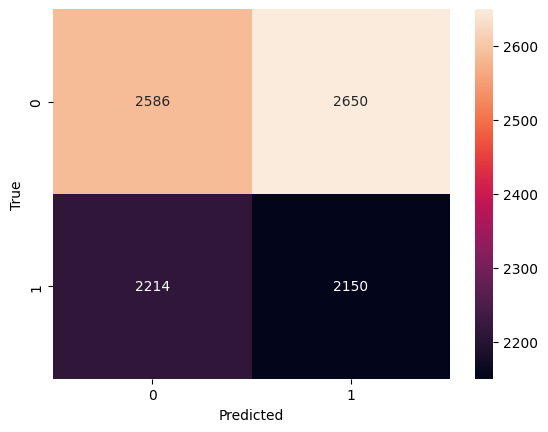

In [39]:
# Convert predictions to class labels (assuming binary classification)
# predicted_labels = np.argmax(predictions, axis=1)

# Import the confusion_matrix function from sklearn.metrics
from sklearn.metrics import confusion_matrix

# Calculate the confusion matrix
cm = confusion_matrix(predicted_labels, validation_labels)

# Print the confusion matrix
print(cm)

# Import the seaborn library for plotting
import seaborn as sns
import matplotlib.pyplot as plt

# Plot the confusion matrix as a heatmap
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [43]:
thresholder = lambda x: 1 if x > 0.5 else 0
# predicted_labels = predictions.apply_along_axis(lambda x: 1 if x > 0.5 else 0)
predictions

predicted_labels = np.array([thresholder(x) for x in predictions])
# predicted_labels = np.argmax(predicted_labels, axis=0)
predicted_labels
predicted_classes = np.where(predictions > 0.5, 1, 0).flatten()

accuracy
confusion matrix
delay of predictions

In [42]:
print(predicted_labels[0:10])
print(validation_labels[0:10])	

[0 1 0 0 0 0 1 1 1 0]
[0 0 0 0 0 0 0 0 0 0]


In [46]:
print(validation_generator.classes[0:100])

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
